In [1]:
import matplotlib.pyplot as plt

import numpy as np 
import scipy
from scipy.special import roots_legendre, factorial
from functools import partial

from einops import repeat, rearrange
np.random.seed(0)

In [2]:
def rl2_error(est, ref):
    if len(est.shape) == 2:
        b, n = est.shape 
    elif len(est.shape) == 3:
        b, c, n = est.shape 
    return ((((est - ref)**2).sum(axis=-1))**0.5 / ((ref**2).sum(axis=-1))**0.5).mean()

In [3]:
def ReLU(x, n):
    # ReLU activation function
    # n : degree 
    return np.maximum(0,x) ** n 

In [4]:
def GP1D(l,n):
    x = np.linspace(0,1,n)
    y = np.linspace(0,1,n)
    mean = np.zeros_like(x)
    gram = np.exp(-np.abs(x.reshape(-1,1) - y.reshape(1,-1))**2/(2*l**2))
    f = np.random.multivariate_normal(mean, gram)
    return f

In [19]:
def Kernel(x, y):
    return 0.5*(x+y-np.abs(x-y)) - x*y

# def Kernel(x, y):
#     return np.log(np.abs(x-y))

# def Kernel(x, y):
#     return np.cos(x-y)

In [20]:
class KernelOGA1d:
    def __init__(self, nNeuron, nSample, nPts):
        self.nPts = nPts
        self.nNeuron = nNeuron
        self.nSample = nSample
        
        # coords
        h = 1/(nPts - 1)
        x = np.linspace(0,1,nPts)
        y = np.linspace(0,1,nPts)
        

        xx, yy = np.meshgrid(x,y)
        xs, ys = xx.reshape(-1), yy.reshape(-1)
        self.xs = xs
        self.ys = ys
        self.h = h

        # ref kernel
        self.Gref = Kernel(xs, ys).reshape(nPts, nPts)

        # data
        fs = []
        for _ in range(nSample):
            fs.append(GP1D(0.02,nPts))
        self.fs = np.array(fs)
        self.us = h * (self.Gref @ self.fs.T).T

        # learned kernel
        self.Gk = np.zeros((nPts, nPts))
        self.gbasis = []
        self.uhbasis = []

        # neural network
        self.act = partial(ReLU, n=1)
        self.Alpha = np.zeros((nNeuron, 1))
        self.WB = np.zeros((nNeuron, 3))
        self.X = np.c_[xs, ys, np.ones_like(xs)]

        # wb search 
        self.nw = 2 
        self.nb = 2001
        self.nParam = (self.nw)**2 * self.nb
        self.brute_forward()
        
        # current neuron k
        self.k = 0
    
    def brute_forward(self):
        Wx = np.linspace(-1,1, self.nw)
        Wy = np.linspace(-1,1, self.nw)
        B = np.linspace(-2,2, self.nb)
        wwx, wwy, bb = np.meshgrid(Wx, Wy, B)
        wxs = wwx.reshape(-1)
        wys = wwy.reshape(-1)
        bs = bb.reshape(-1)
        self.wxs = wxs 
        self.wys = wys 
        self.bs = bs

        gs = []
        for wx, wy, b in zip(wxs, wys, bs):
            gs.append(self.act(wx * self.xs + wy * self.ys + b))
        self.gs = np.array(gs).reshape(self.nParam, self.nPts, self.nPts)
        self.uhss = self.h * rearrange(self.gs @ self.fs.T, 'b n s -> b s n')
    
    def brute_search(self):
        uts = self.h * rearrange(self.Gk @ self.fs.T, 'n s -> s n')
        rG = self.h * ((self.us - uts) * self.uhss).sum(axis=(1,2))
        E = -0.5 * rG ** 2 
        idx = np.argmin(E)
        # print(idx)
        wxk, wyk, bk = self.wxs[idx], self.wys[idx], self.bs[idx]
        gk = self.gs[idx]
        uhk = self.uhss[idx]
        return wxk, wyk, bk, gk, uhk
    
    def projection(self):
        uhsub = np.array(self.uhbasis)
        A = self.h * np.einsum('kns,pns->kp', uhsub, uhsub)
        b = self.h * (uhsub * self.us).sum(axis=(1,2))
        alpha_k = scipy.linalg.solve(A, b)
        return alpha_k

    def optimize(self):
        for k in range(self.nNeuron):
            wxk, wyk, bk, gk, uhk = self.brute_search()
            self.gbasis.append(gk)
            self.uhbasis.append(uhk)
            alpha_k = self.projection()

            # update params 
            self.WB[k,0] = wxk 
            self.WB[k,1] = wyk 
            self.WB[k,2] = bk 
            self.Alpha[:k+1] = alpha_k.reshape(-1,1)

            # update Gk
            self.Gk = (self.Alpha.T @ self.act(self.WB @ self.X.T)).reshape(self.nPts, self.nPts)

            if k in [2, 4, 8, 16, 32, 64, 128, 256]:
                l2 = ((self.Gk - self.Gref)**2).sum()**0.5 / ((self.Gref)**2).sum()**0.5
                print('{:}th - {:.4e}'.format(k, l2))

In [21]:
model = KernelOGA1d(257, 10, 513)

In [22]:
model.optimize()

2th - 4.8032e-01
4th - 1.6791e-01
8th - 7.9671e-02
16th - 3.0391e-02
32th - 9.8226e-03
64th - 1.2672e-03


KeyboardInterrupt: 

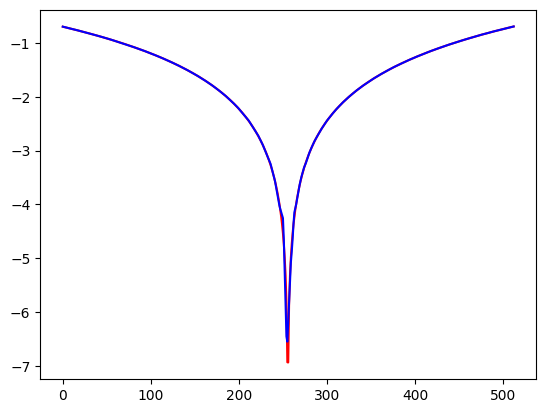

In [17]:
plt.plot(model.Gref[255], '-r', label='Exact')
plt.plot(model.Gk[255], '-b', label='OGA')

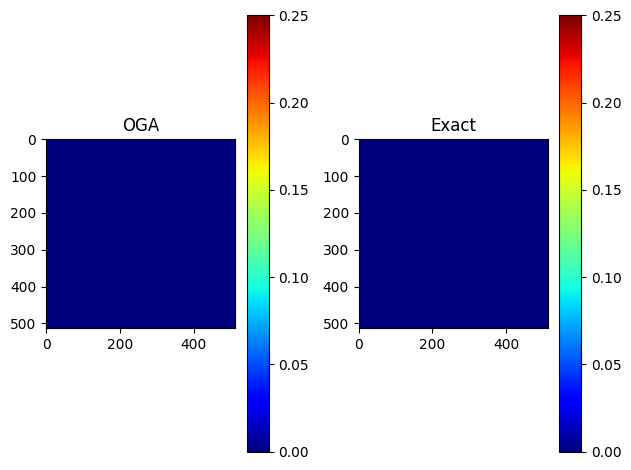

In [18]:
plt.subplot(121)
plt.imshow(model.Gk, vmin=0, vmax=0.25, cmap='jet')
plt.title('OGA')
plt.colorbar()
plt.subplot(122)
plt.imshow(model.Gref, vmin=0, vmax=0.25, cmap='jet')
plt.title('Exact')
plt.colorbar()
plt.tight_layout()